<a href="https://colab.research.google.com/github/Stray-Weights/Dlthon_01_Motocycle_Night_Ride/blob/main/aa-in/260210_dltone_Motorcycle_Night_Rider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 모델 구현 (이아인)
사전준비

In [ ]:
# 구글 드라이브 마운트 & 소스파일 가져오기
from google.colab import drive
from IPython.display import clear_output, HTML, display
import ipywidgets as widgets
import os

drive.mount('/content/drive')
clear_output()

WEEK = 'week7/dltone/dataset'
mypath = os.path.join('/content/drive/MyDrive/Aiffel', WEEK)

def info_msg(msg, style=1, width='450px'):
    # color = '#2ecc71' if style == 1 else '#e67e22'
    color = '#3498db' if style == 1 else '#e67e22'
    mark = '\u2714' if style == 1 else '\u26A0 Warning: '

    html_code = f"""
    <div style="
        background-color: {color};
        color: white;
        padding: 20px 20px;
        border-radius: 15px;
        width: {width};
        text-align: center;
        font-family: 'Malgun Gothic', sans-serif;
        font-weight: bold;
        font-size: 16px;

        margin: 12px 0;
    ">
        {mark} {msg}
    </div>
    """
    display(HTML(html_code))

print(mypath)
info_msg('Google Drive has mounted.', 1)

# 임시 폴더 생성
!mkdir -p "source/images"
!mkdir -p "source/models"

/content/drive/MyDrive/Aiffel/week7/dltone/dataset


In [ ]:
# 구글 드라이브에서 데이터셋 복사해오기
!cp -r "$mypath/." "/content/source"

# 복사된 폴더 내의 파일 개수 확인
qty = !find /content/source/images -type f | wc -l

info_msg(f'{int(qty[0])}개의 이미지들을 성공적으로 가져왔습니다.', 1)

In [ ]:
! pip install opencv-python

### 체크포인트  
  - 출력 형태([1, 6, 512, 512])를 확인할 것.
---

In [ ]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt

# Device 설정 - 코랩의 GPU 사용 여부 체크
# [런타임] - [런타임 유형 변경]에서 T4 GPU 선택 권장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

info_msg(f"현재 사용 중인 장치: {device}", 1)

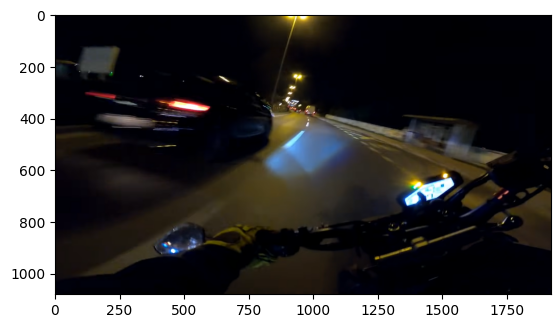

In [ ]:
# 샘플용으로 이미지 한장 확인
img1 = cv2.imread("/content/source/images/Screenshot (309).png")
img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_RGB)
plt.show()

## 1.1 DeepLabv3+ 아키텍처
DeepLabv3+ with ResNet-50 Backbone
### 1.1.1 모델 준비

- `eval()`은 모델을 '평가(추론)' 모드로 바꿈. 학습을 위해서는 `.train()` 사용
- 손실함수: Dice Loss
  - 야간 주행 영상에서 '차선(Lanemark)'은 전체 픽셀의 1%도 안 될 수 있음.
  픽셀 개별의 정답 여부만 따지는 CrossEntropy의 한계를 극복하기 위해, 예측 영역과 실제 영역의 교집합을 극대화하는 Dice Loss는 작은 객체도 놓치지 않게 만듦.
  CrossEntropy만 쓰면 모델은 차선을 틀려도 전체 점수에 영향이 적다고 판단해 차선을 포기해버림.

- 최적화(Optimizer): AdamW
  - 적은 데이터(200장)에서 모델이 노이즈까지 외워버리는 현상을 수학적으로 억제하여 모델의 성능을 일반화 해줌.

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

# 1. ResNet50 기반 DeepLabv3 로드 (사전 학습 가중치 포함)
#    weights='DEFAULT'는 pretrained=True와 동일함.
model = deeplabv3_resnet50(weights='DEFAULT')

# 2. 출력 클래스 수정 (6개 클래스)
NUM_CLASSES = 6

# 메인 분류기 수정
in_channels = model.classifier[4].in_channels
model.classifier[4] = torch.nn.Conv2d(
    in_channels, NUM_CLASSES, kernel_size=(1, 1)
)

# 보조 분류기 수정
in_channels_aux = model.aux_classifier[4].in_channels
model.aux_classifier[4] = torch.nn.Conv2d(
    in_channels_aux, NUM_CLASSES, kernel_size=(1, 1)
)

model.to(device)
print("="*30)
print("ResNet50 백본 기반 DeepLabv3 설정 완료")
print(f"최종 출력 채널: {model.classifier[4].out_channels}")
print("="*30)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 152MB/s]


ResNet50 백본 기반 DeepLabv3 설정 완료
최종 출력 채널: 6


### Baseline Visualization
- 학습 전 모델이 해석한 이미지 결과값

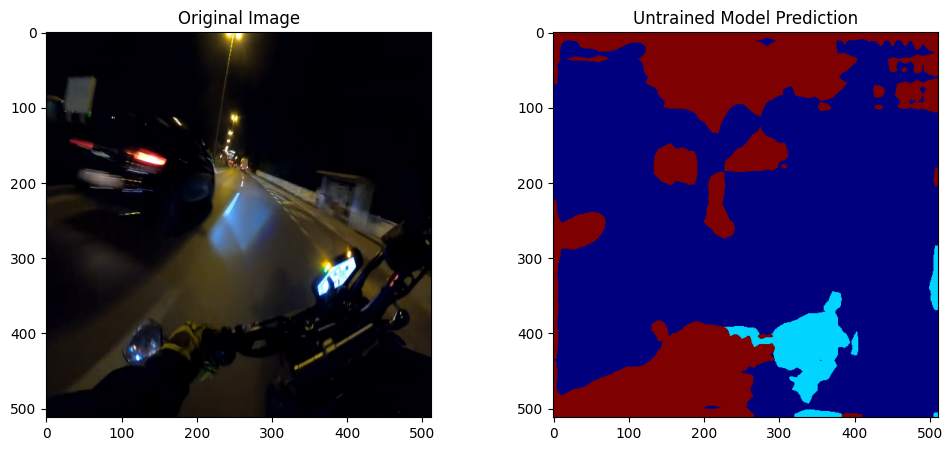

In [ ]:
# 1. 테스트용 더미 이미지 또는 실제 이미지 한 장 준비

# 전처리 파이프라인 (전처리 팀의 규격과 동일하게 설정할 예정)
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img1_RGB).unsqueeze(0).to(device)

# 2. 모델을 평가 모드로 설정하고 추론 (학습 전 상태)
model.to(device) # 모델을 GPU로 이동
model.eval()

with torch.no_grad():
    # DeepLabv3의 출력은 딕셔너리 형태
    output = model(input_tensor)['out'] # 결과: (1, 6, 512, 512)
    # 6개 채널 중 가장 확률이 높은 클래스 인덱스만 추출
    # dim=1 (클래스 차원)에서 최대값을 찾고, squeeze(0)로 배치 차원 제거
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# 3. 결과 시각화
plt.figure(figsize=(12, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(img1_RGB, (512, 512), interpolation=cv2.INTER_LINEAR))

plt.title("Original Image")

# 모델의 예측 결과 (Color map 적용)
plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap='jet')
plt.title("Untrained Model Prediction")

plt.show()

### 손실함수 및 최적화 설정

- Dice Loss: 클래스 불균형 해결

In [ ]:
# 1. Dice Loss 정의 (클래스 불균형 해결사)
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
        # predict: (Batch, 6, H, W), target: (Batch, H, W)
        predict = torch.softmax(predict, dim=1)

        # 정답(target)을 One-hot 인코딩으로 변환 (Batch, 6, H, W)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=6).permute(0, 3, 1, 2).float()

        intersection = (predict * target_one_hot).sum(dim=(0, 2, 3))
        union = predict.sum(dim=(0, 2, 3)) + target_one_hot.sum(dim=(0, 2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


# 2. 손실 함수 및 최적화 도구 설정
#   세그멘테이션에서 손실함수 혼합하기: CrossEntropy와 DiceLoss를 섞어서 사용
criterion_ce = torch.nn.CrossEntropyLoss()
criterion_dice = DiceLoss()

# AdamW: Adam에 가중치 감쇠(Weight Decay)를 개선한 알고리즘. 과적합 방지에 탁월.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# 학습률 스케줄러: 학습이 진행됨에 따라 학습률을 조금씩 낮춰 정교하게 수렴하도록 함.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
# AdamW와 Dice + CE 복합 손실 함수를 사용
def train_one_epoch(model, dataloader, optimizer, criterion_ce, criterion_dice, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device) # (Batch, H, W)

        optimizer.zero_grad() # 그래디언트 초기화

        # 1. Forward Pass
        outputs = model(images)['out'] # (Batch, 6, H, W)

        # 2. Loss 계산 (CE + Dice 복합 손실)
        loss_ce = criterion_ce(outputs, masks)
        loss_dice = criterion_dice(outputs, masks)
        loss = (0.5 * loss_ce) + (0.5 * loss_dice) # 1:1 비율로 혼합

        # 3. Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# --- 실제 학습 실행부 ---
num_epochs = 30 # 데이터가 200장이므로 에폭을 충분히 가져가되 과적합 주의
best_loss = float('inf')

for epoch in range(num_epochs):
    # 훈련 세트로 학습
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion_ce, criterion_dice, device)

    # [검증 파트 - 기능 구현 팀에게 요청할 부분]
    # val_loss = validate(model, val_loader, criterion_ce, criterion_dice, device)

    scheduler.step() # 학습률 조정

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}")

    # 최적 모델 저장 (Early Stopping 대용)
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), 'best_model_resnet50.pth')
        print("Model Saved!")

NameError: name 'train_loader' is not defined